In [1]:
!pip install -q rarfile pydicom pillow tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 54.7 MB/s eta 0:00:00


In [2]:
import os, glob, zipfile, shutil
from google.colab import files
from tqdm import tqdm
from PIL import Image

# Upload your file
print("Upload your images folder as a zip/rar OR individual images")
uploaded = files.upload()

DATA_ROOT = "/content/images"
os.makedirs(DATA_ROOT, exist_ok=True)

# Extract uploaded dataset
for fn in uploaded:
    if fn.endswith(".zip"):
        with zipfile.ZipFile(fn, 'r') as z:
            z.extractall(DATA_ROOT)
    elif fn.endswith(".rar"):
        import rarfile
        rf = rarfile.RarFile(fn)
        rf.extractall(DATA_ROOT)
    else:
        shutil.move(fn, os.path.join(DATA_ROOT, fn))

print("Images extracted to:", DATA_ROOT)


Upload your images folder as a zip/rar OR individual images


Saving images.rar to images.rar
Images extracted to: /content/images


In [3]:
OUT = "/content/processed_images"
os.makedirs(OUT, exist_ok=True)

# Collect all image files
extensions = ["png", "jpg", "jpeg", "tif", "tiff", "bmp"]
paths = []

for ext in extensions:
    paths += glob.glob(os.path.join(DATA_ROOT, "**", f"*.{ext}"), recursive=True)

print("Found", len(paths), "images")

# Convert to grayscale 256×256 PNG
count = 0
for p in tqdm(paths):
    try:
        img = Image.open(p).convert("L")
        img = img.resize((256,256), Image.LANCZOS)
        img.save(os.path.join(OUT, f"img_{count:05d}.png"), "PNG")
        count += 1
    except:
        pass

print("Processed:", count, "images")


Found 941 images


100%|██████████| 941/941 [00:10<00:00, 85.70it/s] 

Processed: 941 images


In [4]:
import random, shutil, glob

random.seed(42)
imgs = glob.glob(OUT + "/*.png")
random.shuffle(imgs)

n = len(imgs)
train = imgs[:int(0.8*n)]
val   = imgs[int(0.8*n):int(0.9*n)]
test  = imgs[int(0.9*n):]

for d in ["train", "val", "test"]:
    os.makedirs(f"/content/data/{d}", exist_ok=True)

for x in train: shutil.copy(x, "/content/data/train")
for x in val: shutil.copy(x, "/content/data/val")
for x in test: shutil.copy(x, "/content/data/test")

print("Train:",len(train),"Val:",len(val),"Test:",len(test))


Train: 752 Val: 94 Test: 95


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class ClinicalDataset(Dataset):
    def __init__(self, folder):
        self.files = glob.glob(folder + "/*.png")
        self.t = transforms.ToTensor()  # Converts to 1×256×256
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("L")
        return self.t(img)


In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

class Embedder(nn.Module):
    def __init__(self, wm_len=32):
        super().__init__()
        self.down = ConvBlock(2, 32)
        self.mid  = ConvBlock(32, 64)
        self.up   = ConvBlock(64, 32)
        self.out  = nn.Conv2d(32, 1, 1)
        self.sig  = nn.Sigmoid()

    def forward(self, img, wm_map):
        x = torch.cat([img, wm_map], dim=1)
        x = self.down(x)
        x = self.mid(x)
        x = self.up(x)

        residual = (self.sig(self.out(x)) - 0.5) * 0.03
        watermarked = torch.clamp(img + residual, 0., 1.)
        return watermarked

class Extractor(nn.Module):
    def __init__(self, wm_len=32):
        super().__init__()
        self.cnn = nn.Sequential(
            ConvBlock(1, 32),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(32, wm_len)

    def forward(self, x):
        f = self.cnn(x).view(x.size(0), -1)
        return self.fc(f)


In [8]:
import numpy as np


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_ds = ClinicalDataset("/content/data/train")
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

wm_len = 32
embedder = Embedder(wm_len).to(device)
extractor = Extractor(wm_len).to(device)

optimiser = optim.Adam(list(embedder.parameters()) + list(extractor.parameters()), lr=1e-4)

mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()

def make_bits(batch, L=32, H=256, W=256):
    bits = torch.randint(0,2,(batch,L)).float().to(device)
    maps = []
    for b in range(batch):
        v = bits[b].cpu().numpy()
        tiled = (np.tile(v, int(np.ceil(H*W/L)))[:H*W]
                 .reshape(H,W))
        maps.append(tiled)
    maps = torch.tensor(np.stack(maps)).unsqueeze(1).float().to(device)
    return bits, maps

for epoch in range(15):
    for imgs in train_loader:
        imgs = imgs.to(device)
        B = imgs.size(0)

        bits, wm_map = make_bits(B)

        wm_imgs = embedder(imgs, wm_map)
        preds   = extractor(wm_imgs)

        loss_img = mse(wm_imgs, imgs)
        loss_wm  = bce(preds, bits)

        loss = 20*loss_img + loss_wm

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f"Epoch {epoch+1}/15 | Loss={loss.item():.4f}")


Epoch 1/15 | Loss=0.6923
Epoch 2/15 | Loss=0.6950
Epoch 3/15 | Loss=0.7001
Epoch 4/15 | Loss=0.6932
Epoch 5/15 | Loss=0.6952
Epoch 6/15 | Loss=0.6906
Epoch 7/15 | Loss=0.6914
Epoch 8/15 | Loss=0.6933
Epoch 9/15 | Loss=0.6924
Epoch 10/15 | Loss=0.6932
Epoch 11/15 | Loss=0.6915
Epoch 12/15 | Loss=0.6930
Epoch 13/15 | Loss=0.6952
Epoch 14/15 | Loss=0.6918
Epoch 15/15 | Loss=0.6928


Original bits:       [1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 1.]
Extracted bits:      [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 1. 1. 1. 0. 1. 1.]


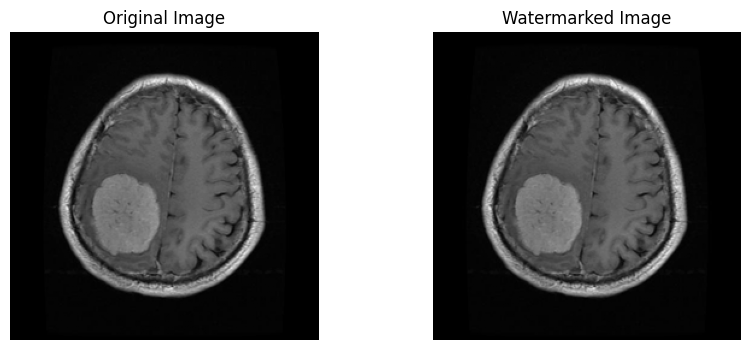

In [11]:
import numpy as np
from matplotlib import pyplot as plt
import torch

embedder.eval()
extractor.eval()

# ---- Sample batch ----
sample = next(iter(train_loader)).to(device)

# ---- Generate random watermark bits and watermark map ----
bits, wm_map = make_bits(1)   # batch size = 1

# ---- Select first image from the batch ----
original = sample[0:1]  # shape [1,1,256,256]

# ---- Embed watermark ----
wm_img = embedder(original, wm_map)

# ---- Extract watermark ----
pred_bits = extractor(wm_img).sigmoid().detach().cpu().numpy()[0]
pred_bits_rounded = np.round(pred_bits)

# ---- Print comparison ----
print("Original bits:      ", bits[0].cpu().numpy())
print("Extracted bits:     ", pred_bits_rounded)

# ---- Show images ----
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(original[0].detach().cpu().squeeze(), cmap='gray')
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Watermarked Image")
plt.imshow(wm_img[0].detach().cpu().squeeze(), cmap='gray')
plt.axis("off")

plt.show()


exporting the current model

In [12]:
# SAVE TRAINED MODELS
torch.save(embedder.state_dict(), "embedder.pth")
torch.save(extractor.state_dict(), "extractor.pth")

print("Models exported successfully!")


Models exported successfully!


loading the model

In [13]:
# Load models back
embedder = Embedder().to(device)
extractor = Extractor().to(device)

embedder.load_state_dict(torch.load("embedder.pth", map_location=device))
extractor.load_state_dict(torch.load("extractor.pth", map_location=device))

embedder.eval()
extractor.eval()

print("Models loaded and ready to use!")


Models loaded and ready to use!


In [14]:
import cv2
import numpy as np
import torch

def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256,256))
    img = img.astype(np.float32) / 255.0
    img = torch.tensor(img).unsqueeze(0).unsqueeze(0)  # [1,1,256,256]
    return img.to(device)

def save_image(tensor, path):
    arr = tensor.detach().cpu().squeeze().numpy() * 255
    cv2.imwrite(path, arr.astype(np.uint8))


# -------------------------------
# MAIN FUNCTION TO MAKE WATERMARKED IMAGE
# -------------------------------
def embed_watermark(image_path, output_path):
    embedder.eval()

    img = load_image(image_path)

    # Generate random watermark bits
    bits, wm_map = make_bits(1)

    # Embed watermark
    wm_img = embedder(img, wm_map)

    # Save result
    save_image(wm_img, output_path)

    print("Watermarked image saved to:", output_path)
    return bits


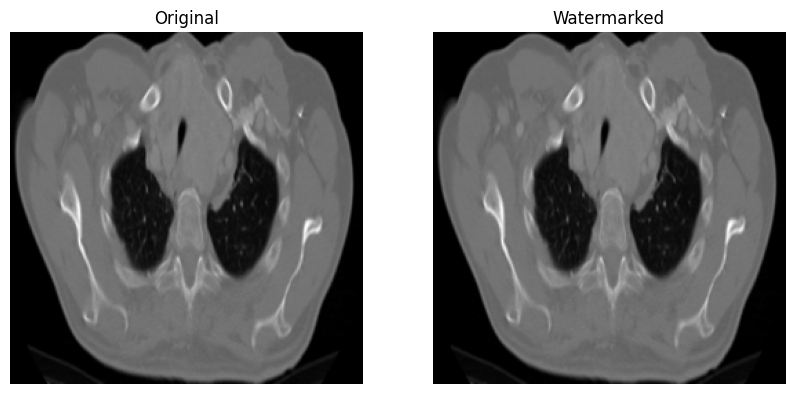

Extracted bits: 00111110001011000100010100111010
Extracted text: >,E:


In [22]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
#  MODEL DEFINITIONS
# -----------------------------

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

class Embedder(nn.Module):
    def __init__(self, wm_len=32):
        super().__init__()
        self.down = ConvBlock(2, 32)
        self.mid  = ConvBlock(32, 64)
        self.up   = ConvBlock(64, 32)
        self.out  = nn.Conv2d(32, 1, 1)
        self.sig  = nn.Sigmoid()

    def forward(self, img, wm_map):
        x = torch.cat([img, wm_map], dim=1)
        x = self.down(x)
        x = self.mid(x)
        x = self.up(x)

        residual = (self.sig(self.out(x)) - 0.5) * 0.03
        watermarked = torch.clamp(img + residual, 0., 1.)
        return watermarked

class Extractor(nn.Module):
    def __init__(self, wm_len=32):
        super().__init__()
        self.cnn = nn.Sequential(
            ConvBlock(1, 32),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(32, wm_len)

    def forward(self, x):
        f = self.cnn(x).view(x.size(0), -1)
        return self.fc(f)

# -----------------------------
#  LOAD MODELS
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

embedder = Embedder(32).to(device)
extractor = Extractor(32).to(device)

embedder.load_state_dict(torch.load("embedder.pth", map_location=device))
extractor.load_state_dict(torch.load("extractor.pth", map_location=device))

embedder.eval()
extractor.eval()

# -----------------------------
#  TEXT ↔ BIT FUNCTIONS
# -----------------------------
def text_to_bits(text, length=32):
    bits = ''.join(format(ord(c), '08b') for c in text)
    bits = bits[:length]
    bits += '0' * (length - len(bits))
    return np.array(list(bits)).astype(np.float32)

def bits_to_text(bits):
    chars = []
    bits = list(bits)
    for i in range(0, len(bits), 8):
        byte = bits[i:i+8]
        if len(byte) < 8:
            break
        chars.append(chr(int(''.join(byte), 2)))
    return ''.join(chars)

# -----------------------------
#  IMAGE LOADING
# -----------------------------
transform = T.Compose([
    T.Grayscale(),
    T.Resize((256,256)),
    T.ToTensor()
])

def load_img(path):
    img = Image.open(path).convert("RGB")
    return transform(img).unsqueeze(0)

# -----------------------------
#  FIXED WATERMARK MAP CREATOR
# -----------------------------
def make_wm_map(bits, H=256, W=256):
    bits = np.array(bits).astype(np.float32)
    tiled = np.tile(bits, (H * W // len(bits) + 1))[:H*W]
    wm_map = tiled.reshape(1, 1, H, W)
    return torch.tensor(wm_map, dtype=torch.float32)

# -----------------------------
#  WATERMARK EMBEDDING
# -----------------------------
def embed_watermark(image_path, message):
    img = load_img(image_path).to(device)

    wm_bits = text_to_bits(message, 32)
    wm_map = make_wm_map(wm_bits).to(device)

    with torch.no_grad():
        wm_img = embedder(img, wm_map)

    return img, wm_img, wm_bits

# -----------------------------
#  WATERMARK EXTRACTION
# -----------------------------
def extract_watermark(wm_img):
    with torch.no_grad():
        pred = extractor(wm_img).cpu().numpy().flatten()

    pred_bits = (pred > 0).astype(int).astype(str)
    return pred_bits

# -----------------------------
#  RUN EXAMPLE
# -----------------------------
original, watermarked, true_bits = embed_watermark(
    "/content/images/images/000002.png", "H"
)

# Show images
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(original.squeeze().cpu(), cmap='gray')
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Watermarked")
plt.imshow(watermarked.squeeze().cpu(), cmap='gray')
plt.axis("off")

plt.show()

# Extract watermark
pred_bits = extract_watermark(watermarked)
print("Extracted bits:", ''.join(pred_bits))
print("Extracted text:", bits_to_text(pred_bits))
